# FaIR with input data
### Learning out how to run FaIR with input data- EDGAR CO2 observations (1970-2022)
#### Erica Simon, 01/22/2024




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

### Create instance

In [2]:
f = FAIR(ghg_method='leach2021')

### Define time horizon

In [3]:
# reconstruct hist
f.define_time(1970, 2023, 1)

### Define scenarios

In [4]:
f.define_scenarios(['test1'])

### Define configs

In [5]:
# parameter ensemble
fair_params_1_2_0_obj = pooch.retrieve(
    url = 'https://zenodo.org/record/8399112/files/calibrated_constrained_parameters.csv',
    known_hash = 'md5:de3b83432b9d071efdd1427ad31e9076',
)

In [6]:
df_configs = pd.read_csv(fair_params_1_2_0_obj, index_col=0)
configs = df_configs.index  # this is used as a label for the "config" axis
f.define_configs(configs)

In [7]:
df_configs.head()

,clim_gamma,clim_c1,clim_c2,clim_c3,clim_kappa1,clim_kappa2,clim_kappa3,clim_epsilon,clim_sigma_eta,clim_sigma_xi,...,fscale_Stratospheric water vapour,fscale_Land use,fscale_Volcanic,fscale_solar_amplitude,fscale_solar_trend,fscale_Light absorbing particles on snow and ice,fscale_Contrails,fscale_CO2,cc_co2_concentration_1750,seed
1230,1.769676,3.624462,7.990559,351.593545,1.428812,3.185628,0.492204,0.387406,0.494609,0.619379,...,1.510615,0.786075,0.937678,0.460204,-0.016256,1.686514,1.405533,0.987613,277.625450,1846533
1715,2.143142,4.889789,21.813475,101.917617,1.970173,1.071125,1.328655,1.465390,0.394019,0.367552,...,0.876840,1.188071,1.038958,0.343548,-0.056502,1.043790,0.703501,0.968117,279.909140,2040048
2658,4.177349,5.204886,20.998936,21.085816,0.797920,2.526630,1.000076,1.251896,0.653188,0.547847,...,0.383282,0.914854,0.744196,0.458884,-0.002800,0.544324,0.820430,1.011921,276.858025,2416305
3898,2.044461,4.592895,14.656268,15.303202,0.620333,2.832756,1.154977,2.160007,0.461311,0.260020,...,1.631921,0.881545,1.073446,1.016936,-0.010243,1.276720,0.724910,0.948908,278.869631,2911065
5915,4.812140,4.582716,9.051207,160.760900,0.944823,1.820105,1.024776,1.131748,0.324605,0.425571,...,0.763970,0.908647,1.014453,0.713096,0.010865,1.916141,0.810404,0.963535,278.236615,3715848


### Define species

In [8]:
# going to try just CO2 to start
species = ['CO2']

In [9]:
properties = {
    'CO2': {
        'type': 'co2',
        'input_mode': 'emissions',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False,
    }}

In [10]:
properties

{'CO2': {'type': 'co2',
  'input_mode': 'emissions',
  'greenhouse_gas': True,
  'aerosol_chemistry_from_emissions': False,
  'aerosol_chemistry_from_concentration': False}}

In [11]:
f.define_species(species, properties)

### Create input and output data

In [12]:
# create empty emission and temp arrays
f.allocate()   

### Fill in the data
1. emissions/concentrations
2. initial conditions
3. climate_configs
4. species_configs

#### emissions/concentrations

In [13]:
co2_data = pd.read_csv("~/data/IEA_EDGAR_CO2_1970_2022.csv", index_col="Year")

In [14]:
co2_data

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Year,,,,,,,,,,,,,,,,,,,,,
CO2 Emissions,15825428,15791981,16595636,17571714,17501571,17450419,18448008,19008075,19508790,20047750,...,36066771,36290322,36158867,36256053,36890306,37831881,37824922,35944484,38082177,38522011


In [15]:
co2_np = co2_data.to_numpy()
co2_np

array([[15825428, 15791981, 16595636, 17571714, 17501571, 17450419,
        18448008, 19008075, 19508790, 20047750, 19788048, 19422676,
        19169208, 19307241, 19926542, 20185812, 20541712, 21190601,
        21946997, 22333218, 22516776, 22654819, 22564265, 22672047,
        22891595, 23558161, 24014919, 24484309, 24642505, 24821891,
        25621005, 25938844, 26344013, 27562255, 28846464, 29924600,
        30943465, 32112597, 32307311, 31897679, 33848414, 34911315,
        35380008, 36066771, 36290322, 36158867, 36256053, 36890306,
        37831881, 37824922, 35944484, 38082177, 38522011]])

In [16]:
print(co2_np.shape)
print(f.emissions.shape)

(1, 53)
(53, 1, 1001, 1)


In [17]:
# need to reshape to fit emissions df
co2_np = np.reshape(co2_np, (53,1))
co2_np.shape

(53, 1)

In [18]:
fill(f.emissions, co2_np, scenario='test1', specie='CO2')

#### initial conditions

In [19]:
initialise(f.concentration, 325, specie='CO2')   # taken from EU EEA
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

#### climate configs

In [22]:
fill(f.climate_configs["ocean_heat_transfer"], [1.1, 1.6, 0.9])
fill(f.climate_configs["ocean_heat_capacity"], [8, 14, 100])
fill(f.climate_configs["deep_ocean_efficacy"], 1.1)

In [23]:
f.climate_configs

<xarray.Dataset>
Dimensions:                (config: 1001, layer: 3)
Coordinates:
  * config                 (config) int64 1230 1715 2658 ... 1497105 1498424
  * layer                  (layer) int64 0 1 2
Data variables:
    ocean_heat_transfer    (config, layer) float64 1.1 1.6 0.9 ... 1.1 1.6 0.9
    ocean_heat_capacity    (config, layer) float64 8.0 14.0 100.0 ... 14.0 100.0
    deep_ocean_efficacy    (config) float64 1.1 1.1 1.1 1.1 ... 1.1 1.1 1.1 1.1
    stochastic_run         (config) bool False False False ... False False False
    sigma_eta              (config) float64 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    sigma_xi               (config) float64 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    gamma_autocorrelation  (config) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    seed                   (config) uint32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    use_seed               (config) bool False False False ... False False False
    forcing_4co2           (config) float64 8.0 8.0 8.0 8.0 ... 8.0 8.0 8.0 8.0

#### species configs

In [26]:
# fill with default values
f.fill_species_configs()

In [27]:
f.species_configs

<xarray.Dataset>
Dimensions:                                   (config: 1001, specie: 1,
                                               gasbox: 4)
Coordinates:
  * config                                    (config) int64 1230 ... 1498424
  * specie                                    (specie) <U3 'CO2'
  * gasbox                                    (gasbox) int64 0 1 2 3
Data variables: (12/31)
    tropospheric_adjustment                   (config, specie) float64 0.05 ....
    forcing_efficacy                          (config, specie) float64 1.0 .....
    forcing_temperature_feedback              (config, specie) float64 0.0 .....
    forcing_scale                             (config, specie) float64 1.0 .....
    partition_fraction                        (config, specie, gasbox) float64 ...
    unperturbed_lifetime                      (config, specie, gasbox) float64 ...
    ...                                        ...
    aci_shape                                 (config, specie) float64 0.0 .....
    cl_atoms                                  (specie) float64 0.0
    br_atoms                                  (specie) float64 0.0
    fractional_release                        (config, specie) float64 0.0 .....
    ch4_lifetime_chemical_sensitivity         (config, specie) float64 0.0 .....
    lifetime_temperature_sensitivity          (config) float64 -0.0408 ... -0...

### Run

In [28]:
f.run()

Running 1001 projections in parallel:   0%|          | 0/53 [00:00<?, ?timesteps/s]

Text(0, 0.5, 'Temperature anomaly (K)')

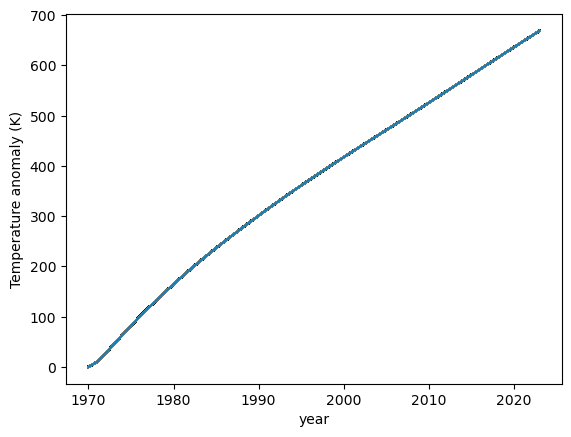

In [29]:
plt.plot(f.timebounds, f.temperature.loc[dict(scenario='test1', layer=0)])
plt.xlabel('year')
plt.ylabel('Temperature anomaly (K)')

Obviously this is not accurate... but a good way of learning how to input datasets